# Prepare Colab environment (install & imports)

In [4]:
# Install required libraries (run once)
!pip install --quiet vaderSentiment textblob wordcloud scikit-learn plotly

# NLTK downloads needed by TextBlob & stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')

# Import common libs
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import os
sns.set(style='whitegrid')
%matplotlib inline


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Upload & load Sentiment140 dataset

In [5]:
from google.colab import files
uploaded = files.upload()  # choose the sentiment140 CSV file you downloaded

# Sentiment140 uses ISO-8859-1 and has no header
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename, encoding='ISO-8859-1', header=None)
df.columns = ["target","id","date","query","user","text"]
df = df[["target","text"]]   # keep only columns we need
df['target'] = df['target'].map({0:0, 4:1})  # 0=negative, 1=positive
print("Shape:", df.shape)
df.head()


Saving training.1600000.processed.noemoticon.csv to training.1600000.processed.noemoticon (1).csv
Shape: (1600000, 2)


,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


# Quick EDA — distribution & sample

In [6]:
print("Label distribution:")
display(df['target'].value_counts(normalize=True))
# show samples
display(df.sample(5, random_state=1))


Label distribution:


,proportion
target,
0,0.5
1,0.5


,target,text
514293,0,i miss nikki nu nu already shes always there ...
142282,0,So I had a dream last night. I remember a sig...
403727,0,@girlyghost ohh poor sickly you (((hugs)) ho...
649503,0,it is raining again
610789,0,@MissKeriBaby wish I was in LA right now


# Text cleaning function

In [7]:
import nltk
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

def clean_text(text):
    if pd.isnull(text): return ""
    text = str(text).lower()
    text = re.sub(r'http\S+', '', text)            # remove URLs
    text = re.sub(r'@\w+', '', text)               # remove mentions
    text = re.sub(r'#', '', text)                  # remove hashtag symbol only
    text = re.sub(r'[^a-z\s]', ' ', text)          # keep letters and spaces
    tokens = [t for t in text.split() if t not in stop and len(t)>1]
    return " ".join(tokens)

# Apply cleaning to a sample first (fast preview)
df['clean_text'] = df['text'].astype(str).apply(clean_text)
df[['text','clean_text']].head()


,text,clean_text
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww bummer shoulda got david carr third day
1,is upset that he can't update his Facebook by ...,upset update facebook texting might cry result...
2,@Kenichan I dived many times for the ball. Man...,dived many times ball managed save rest go bounds
3,my whole body feels itchy and like its on fire,whole body feels itchy like fire
4,"@nationwideclass no, it's not behaving at all....",behaving mad see


# Rule-based sentiment: VADER + TextBlob polarity

In [8]:
# VADER scoring
analyzer = SentimentIntensityAnalyzer()
df['vader_compound'] = df['clean_text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# TextBlob polarity
df['tb_polarity'] = df['clean_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Map to labels for comparison (Positive/Negative/Neutral)
def map_label_score(x, pos=0.05, neg=-0.05):
    if x >= pos: return 1
    if x <= neg: return 0
    return 2  # neutral

df['vader_label'] = df['vader_compound'].apply(map_label_score)
df['tb_label'] = df['tb_polarity'].apply(map_label_score)

# Show agreement with original labels (only for Positive/Negative)
print("VADER vs original (ignore neutrals):")
mask = df['vader_label']!=2
print("Accuracy (VADER vs ground truth):", (df.loc[mask,'vader_label']==df.loc[mask,'target']).mean())

print("TextBlob vs original (ignore neutrals):")
mask2 = df['tb_label']!=2
print("Accuracy (TextBlob vs ground truth):", (df.loc[mask2,'tb_label']==df.loc[mask2,'target']).mean())

df[['text','clean_text','target','vader_compound','vader_label','tb_polarity','tb_label']].sample(6, random_state=2)


VADER vs original (ignore neutrals):
Accuracy (VADER vs ground truth): 0.6930985643690598
TextBlob vs original (ignore neutrals):
Accuracy (TextBlob vs ground truth): 0.6835181054706021


,text,clean_text,target,vader_compound,vader_label,tb_polarity,tb_label
670081,@brodiejay OH IM GOING THERE! Wow Mona Vale is...,oh im going wow mona vale real place afterall ...,0,0.3182,1,-0.075000,0
408251,my baby's growing up,baby growing,0,0.1779,1,0.000000,2
1559739,Painted Black-Rolling Stones..the best!,painted black rolling stones best,1,0.6369,1,0.416667,1
571248,"kk, i'm logging off now BYEZZ!",kk logging byezz,0,0.3612,1,0.000000,2
524639,Shitty shitty shitty news today,shitty shitty shitty news today,0,-0.8957,0,0.000000,2
311150,@Askmewhats * hugs* what's wrong?,hugs wrong,0,0.0258,2,-0.500000,0


# Visualize label distribution & VADER score distribution

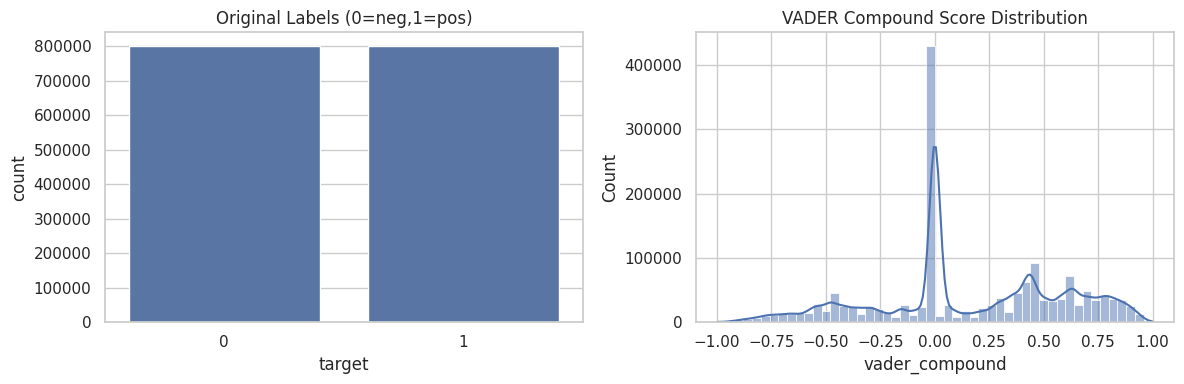

In [9]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.countplot(x='target', data=df)
plt.title('Original Labels (0=neg,1=pos)')
plt.subplot(1,2,2)
sns.histplot(df['vader_compound'], bins=50, kde=True)
plt.title('VADER Compound Score Distribution')
plt.tight_layout()
plt.show()


# Prepare data for ML: train/test split

In [10]:
# For performance and demo, sample the dataset (optional). Remove sampling to use full data.
SAMPLE = 200000  # set None to use full data; careful with runtime/memory
if SAMPLE:
    df_sample = df.sample(SAMPLE, random_state=1).reset_index(drop=True)
else:
    df_sample = df

X = df_sample['clean_text']
y = df_sample['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (160000,) Test shape: (40000,)


# Vectorize text (TF-IDF) and train a simple classifier

In [11]:
# TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=50000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Logistic Regression (fast, strong baseline)
clf = LogisticRegression(max_iter=200, C=1.0, n_jobs=-1)
clf.fit(X_train_tfidf, y_train)

# Predictions
y_pred = clf.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))


Accuracy: 0.775775

Classification Report:
               precision    recall  f1-score   support

           0     0.7831    0.7622    0.7725     19976
           1     0.7689    0.7894    0.7790     20024

    accuracy                         0.7758     40000
   macro avg     0.7760    0.7758    0.7757     40000
weighted avg     0.7760    0.7758    0.7757     40000



# Confusion matrix & error analysis (inspect errors)

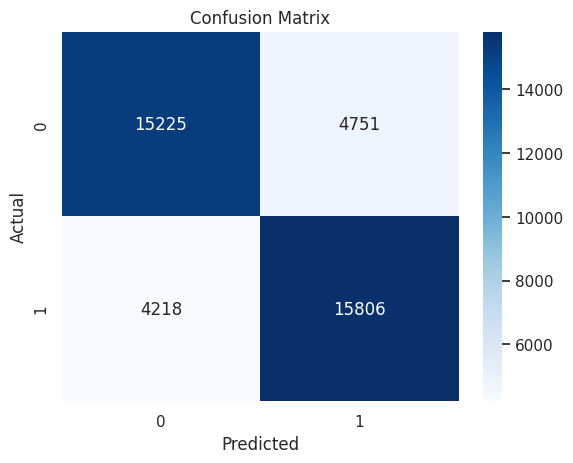

False Positives (predicted positive but actual negative):


,text,clean_text,true,pred
179925,turned like mins ago look later,turned like mins ago look later,0,1
193042,cup special small little bowl fruit salad lunc...,cup special small little bowl fruit salad lunc...,0,1
4938,thinking go bed really hours game natalia go b...,thinking go bed really hours game natalia go b...,0,1
48434,loves blagging free champagne hated taxi drive...,loves blagging free champagne hated taxi drive...,0,1
52235,reflection like longass reflection,reflection like longass reflection,0,1


False Negatives (predicted negative but actual positive):


,text,clean_text,true,pred
43602,bored going southend afternoon,bored going southend afternoon,1,0
133242,tss rainy aftie,tss rainy aftie,1,0
100242,frankfurt internet slow rainy reasons still ny,frankfurt internet slow rainy reasons still ny,1,0
81274,end far start,end far start,1,0
36750,went epydoc got things,went epydoc got things,1,0


In [12]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Show some false positives and false negatives
test_df = pd.DataFrame({'text': X_test, 'clean_text': X_test, 'true': y_test, 'pred': y_pred})
fp = test_df[(test_df['true']==0) & (test_df['pred']==1)].sample(5, random_state=2)
fn = test_df[(test_df['true']==1) & (test_df['pred']==0)].sample(5, random_state=2)
print("False Positives (predicted positive but actual negative):")
display(fp)
print("False Negatives (predicted negative but actual positive):")
display(fn)


# Feature importance (informative n-grams)

In [13]:
# Get top positive and top negative coefficients
import numpy as np
feature_names = np.array(tfidf.get_feature_names_out())
coefs = clf.coef_[0]
top_pos = feature_names[np.argsort(coefs)[-20:]]
top_neg = feature_names[np.argsort(coefs)[:20]]
print("Top positive features:", top_pos[::-1])
print("Top negative features:", top_neg)


Top positive features: ['thanks' 'cant wait' 'thank' 'welcome' 'excited' 'glad' 'amazing'
 'awesome' 'wish luck' 'proud' 'smile' 'great' 'cute' 'congratulations'
 'yay' 'love' 'happy' 'hehe' 'hi' 'congrats']
Top negative features: ['sad' 'miss' 'sick' 'missing' 'sucks' 'poor' 'wish' 'unfortunately' 'ugh'
 'lost' 'hurts' 'hate' 'died' 'sadly' 'bummed' 'headache' 'sorry' 'upset'
 'disappointed' 'cancelled']


# Word clouds for Positive vs Negative tweets (model predictions)

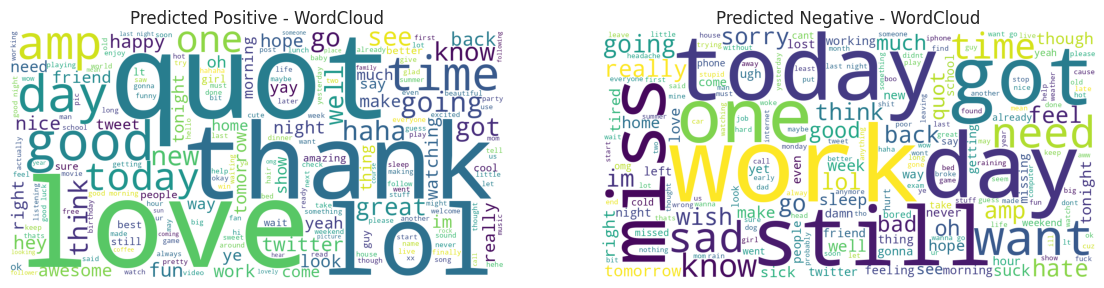

In [14]:
pred_df = pd.DataFrame({'clean_text': X_test, 'pred': y_pred})
pos_text = " ".join(pred_df[pred_df['pred']==1]['clean_text'].astype(str).values)
neg_text = " ".join(pred_df[pred_df['pred']==0]['clean_text'].astype(str).values)

wc = WordCloud(width=1200, height=600, background_color='white', stopwords=STOPWORDS)
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.imshow(wc.generate(pos_text))
plt.title('Predicted Positive - WordCloud')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(wc.generate(neg_text))
plt.title('Predicted Negative - WordCloud')
plt.axis('off')
plt.show()


# Save models & outputs

In [15]:
# Create outputs folder
OUT = '/content/sentiment_outputs'
os.makedirs(OUT, exist_ok=True)

# Save sample results
results = pd.DataFrame({'text': X_test, 'true': y_test, 'pred': y_pred})
results.to_csv(os.path.join(OUT, 'sentiment_test_results.csv'), index=False)

# Save vectorizer and model (pickle)
import joblib
joblib.dump(tfidf, os.path.join(OUT, 'tfidf_vectorizer.joblib'))
joblib.dump(clf, os.path.join(OUT, 'logreg_model.joblib'))

print("Saved outputs to", OUT)


Saved outputs to /content/sentiment_outputs
